# 聚类和k-means聚类算法

- 聚类算法直接从数据的内在性质中学习最优的划分结果或者确定离散标签类型
- sklearn中最简单、 最容易理解的聚类算法可能还得算是 k-means 聚类算法了， 在sklearn.cluster.KMeans 中实现

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # 绘图风格
import numpy as np

ValueError: context must be in paper, notebook, talk, poster

## 1. k-means简介

- k-means 算法在不带标签的多维数据集中寻找确定数量的簇
- 最优的聚类结果需要符合以下两个假设
    - “簇中心点”（cluster center） 是属于该簇的所有数据点坐标的算术平均值
    - 一个簇的每个点到该簇中心点的距离， 比到其他簇中心点的距离短

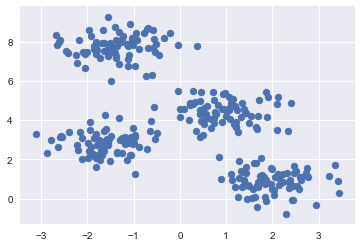

In [7]:
# 生成一个二维数据集，包含4个明显的簇
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:,1], s=50)

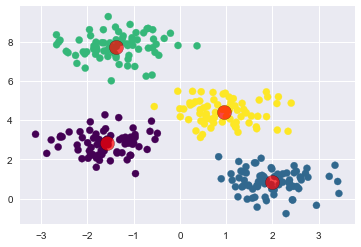

In [13]:
# 使用kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.7, edgecolor='black')

## 2. kmeans算法：期望最大化

### 2.1 期望最大算法概述

- 期望最大化（expectation-maximization， E-M） 是一种非常强大的算法， 应用于数据科学的很多场景中。
    - k-means 是该算法的一个非常简单并且易于理解的应用
- 期望最大化方法包含以下步骤
    - 猜测一些簇中心点
    - 重复直至收敛
        - a. 期望步骤（E-step） ： 将点分配至离其最近的簇中心点
            - 期望步骤（Expectation step） 不断更新每个点是属于哪一个簇的期望值
        - b. 最大化步骤（M-step） ： 将簇中心点设置为所有点坐标的平均值
            - 最大化步骤（Maximization step） 计算关于簇中心点的拟合函数值最大化对应坐标（argmax 函数）
        - 在典型环境下， 每一次重复 E-step 和 M-step 都将会得到更好的聚类效果
- 

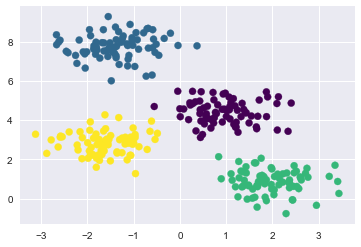

In [14]:
# 一个非常基础的kmeans算法实现
from sklearn.metrics import pairwise_distances_argmin
def find_clusters(X, n_clusters, rseed=2):
    # 1.随机选择簇中心点
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a.基于最近的中心指定标签
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b.根据点的平均值找到新的中心
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c.确认收敛
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### 2.2 使用期望最大化算法时的注意事项

- 2.2.1 可能不会达到全局最优结果
    - 虽然 E–M 算法可以在每一步中改进结果， 但是它并不保证可以获得全局最优的解决方案
    - 例如， 如果在上述简单的步骤中使用一个随机种子（random seed） ， 那么某些初始值可能会导致很糟糕的聚类结果
    - 因此， 该算法通常会用不同的初始值尝试很多遍， 在Scikit-Learn 中通过n_init 参数（默认值是 10）设置执行次数    

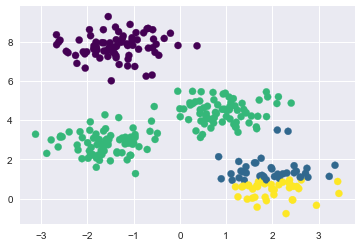

In [15]:
# 如果在上述简单的步骤中使用一个随机种子（random seed） ， 那么某些初始值可能会导致很糟糕的聚类结果
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

 - 2.2.2 簇数量必须事先定好
    - k-means 还有一个显著的问题是：必须事先告诉该算法簇数量，因为它无法从数据中自动学习到簇的数量
    - 可以使用一些复杂的聚类算法
        - 有些算法对每个簇的聚类效果有更好的度量方式（例如高斯混合模型， Gaussian mixturemodels， 详情请参见 5.12 节） 
        - 还有一些算法可以选择一个合适的簇数量（例如 DBSCAN、 均值漂移或者近邻传播， 这些都是sklearn.cluster 的子模块）

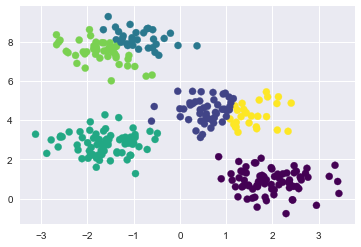

In [16]:
# 找出6个簇的算法
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

 - 2.2.3 k-means 算法只能确定线性聚类边界
    - 当簇中心点呈现非线性的复杂形状时， 该算法通常不起作用
    - k-means 聚类的边界总是线性的， 这就意味着当边界很复杂时，算法会失效
    - 通过一个核变换将数据投影到更高维的空间,可以使用同样的技巧解决 k-means 算法无法处理非线性边界的问题
        - 这种核 k-means 算法在 Scikit-Learn 的 SpectralClustering 评估器中实现
        - 它使用最近邻图（the graph of nearest neighbors） 来计算数据的高维表示，然后用 k-means 算法分配标签

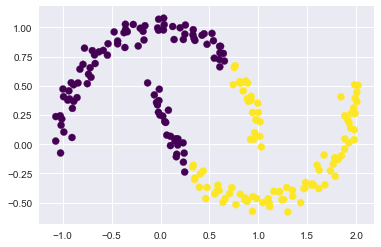

In [17]:
# 在边界很复杂时，kmeans可能会失效
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=0.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


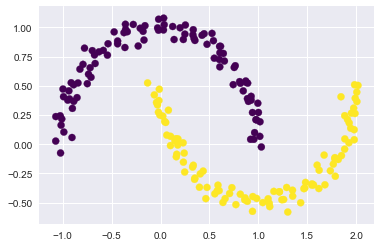

In [19]:
# 核KMEANS算法
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", assign_labels='kmeans')
labels = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

- 2.2.4 当数据量较大时， k-means 会很慢
    - k-means 的每次迭代都必须获取数据集所有的点， 因此随着数据量的增加， 算法会变得缓慢
    - 用批处理（batch-based） k-means 算法来处理这个问题
        - 该算法在 sklearn.cluster.MiniBatchKMeans 中实现
        - 该算法的接口和标准的 KMeans 接口相同
        - 下面的案例将使用这种算法

## 3. 案例

### 3.1 案例1：用kmeans算法处理手写数字

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

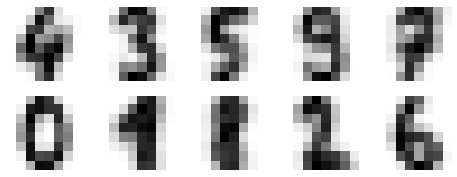

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap='binary')

In [27]:
# 由于 k-means 并不知道簇的真实标签， 因此 0~9 标签可能并不是顺序排列的。 我们可以将每个学习到的簇标签和真实标签进行匹配，从而解决这个问题
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [28]:
# 检查无监督聚类算法在查找相似数字时的准确性
from sklearn.metrics import accuracy_score
print(accuracy_score(digits.target, labels))

0.7935447968836951


Text(92.68, 0.5, 'predicted label')

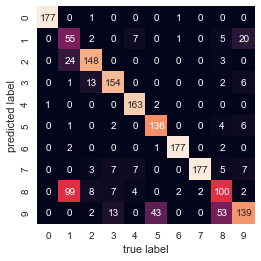

In [29]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=digits.target_names,
           yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')


- 其实还可以更进一步， 使用 t- 分布邻域嵌入算法（详情请参见 5.10节） 在执行 k-means 之前对数据进行预处理。 
- t-SNE 是一个非线性嵌入算法， 特别擅长保留簇中的数据点

In [31]:
from sklearn.manifold import TSNE

# 投影数据
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# 计算类
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# 排列标签
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# 计算准确率
print(accuracy_score(digits.target, labels))

0.9371174179187535


### 3.2 案例2：将kmeans用于图像色彩压缩

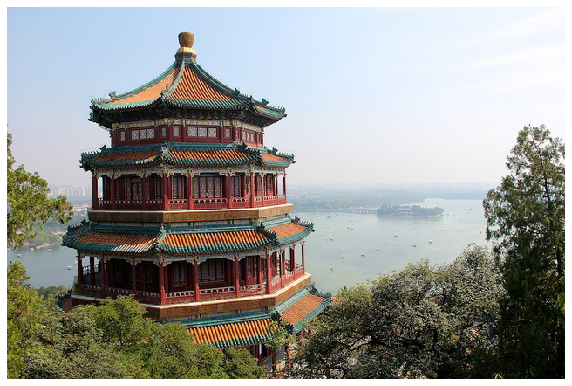

In [33]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [34]:
print(china.data.shape)

(427, 640, 3)


In [36]:
# 可以将这组图像像素转换成三维颜色空间中的一群数据点，
# 先将数据变换为[n_samples, n_features]的形式，然后缩放颜色至其取值为0-1

data = china / 255.0  # 转换成0-1区间值
data = data.reshape(427 * 640, 3)
print(data.shape)

(273280, 3)


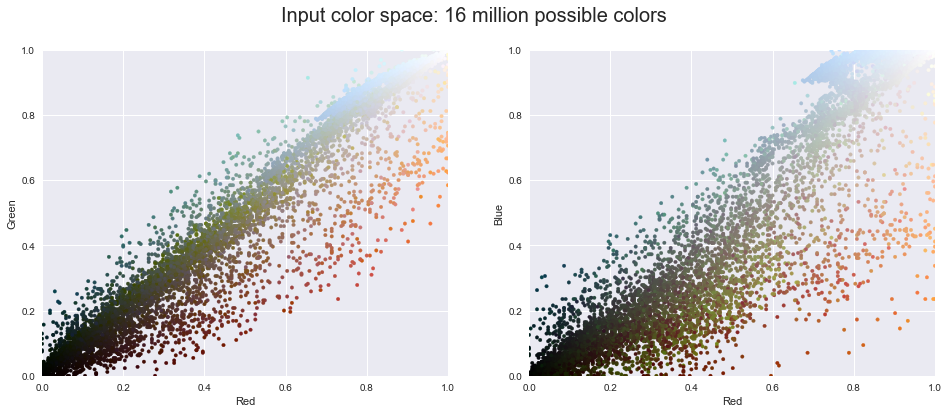

In [38]:
# 在颜色空间中对像素进行可视化
# 只选取包含前10000个像素的子集
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # 随机选取一个子集
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0,1), ylim=(0, 1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0,1), ylim=(0, 1))
    
    fig.suptitle(title, size=20)
    
plot_pixels(data, title='Input color space: 16 million possible colors')

- 对像素空间（特征矩阵） 使用 k-means 聚类， 将 1600 万种颜色（255 × 255 × 255 = 16 581 375） 缩减到 16 种颜色。 
- 因为我们处理的是一个非常大的数据集， 所以将使用 MiniBatchKMeans 算法对数据集的子集进行计算。 
    - 这种算法比标准的 k-means 算法速度更快

(273280, 3)


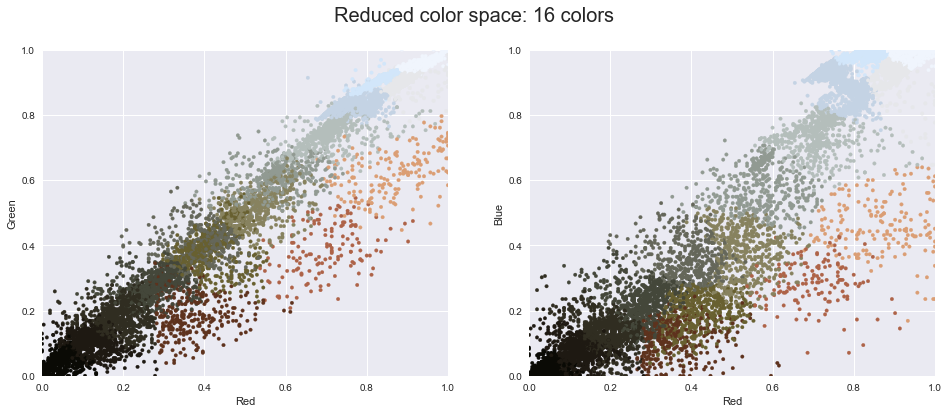

In [41]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
print(new_colors.shape)

plot_pixels(data, colors=new_colors,title='Reduced color space: 16 colors')

- 用计算的结果对原始像素重新着色， 即每个像素被指定为距离其最近的簇中心点的颜色。 
- 用新的颜色在图像空间（427 × 640） ， 而不是像素空间（273 280 × 3） 里重新画图， 展示效果

Text(0.5, 1.0, '16-color Image')

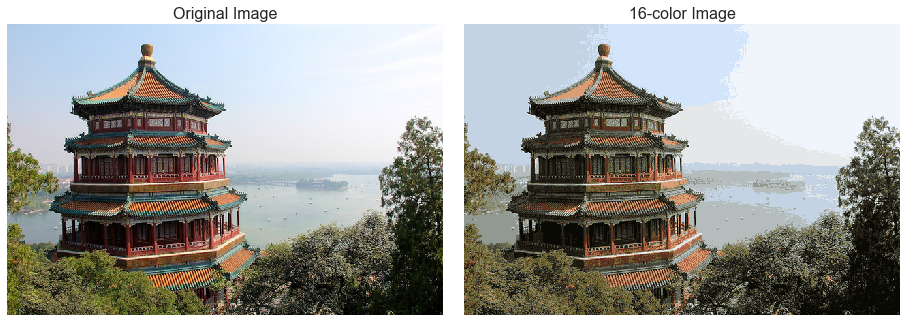

In [43]:
china_recolored = new_colors.reshape(china.shape)
# print(china_recolored.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)